### Unidad II. Regresiones y reducción de dimensionalidad.

## Análisis de varianza unifactorial y multifactorial.

- El análisis de varianza unifactorial paramétrico. Hipótesis necesaria.
 - Análisis de la varianza (ANOVA)
- Complementos del análisis unifactorial. Los tests de rangos, el análisis de contrastes y la descomposición polinomial a la suma de cuadrados.
- Alternativa no paramétricas al ANOVA: el análisis de varianza de Kruskal-Wallis y el test de la mediana.
- Análisis de varianza no Paramétricos para comparar longitudinalmente k variables dependientes: el test de Friedman y el test de Cochran.

### One-way ANOVA

In [7]:
# Pkg.add("ExcelReaders")
using ExcelReaders

using DataFrames

donuts = readxlsheet(DataFrame, "donuts.xls", "Sheet1")

,Fat1,Fat2,Fat3,Fat4
1,164.0,178.0,175.0,155.0
2,172.0,191.0,193.0,166.0
3,168.0,197.0,178.0,149.0
4,177.0,182.0,171.0,164.0
5,156.0,185.0,163.0,170.0
6,195.0,177.0,176.0,168.0


In [8]:
sdonuts = stack(donuts)
head(sdonuts, 10)

,variable,value
1,Fat1,164.0
2,Fat1,172.0
3,Fat1,168.0
4,Fat1,177.0
5,Fat1,156.0
6,Fat1,195.0
7,Fat2,178.0
8,Fat2,191.0
9,Fat2,197.0
10,Fat2,182.0


In [9]:
using Plots
pyplot(size=(300,300))

Plots.PyPlotBackend()

In [10]:
sdonuts[:variable] = ASCIIString[ string(level) for level in sdonuts[:variable] ]
pool!(sdonuts)

In [11]:
describe(sdonuts)

variable
Length  24
Type    Pooled ASCIIString
NAs     0
NA%     0.0%
Unique  4

value
Min      149.0
1st Qu.  165.5
Median   173.5
Mean     173.75
3rd Qu.  179.0
Max      197.0
NAs      0
NA%      0.0%




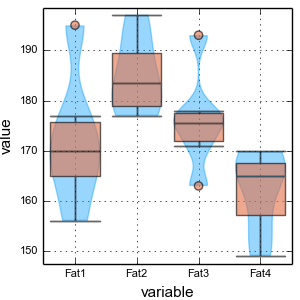

In [12]:
violin(sdonuts, :variable, :value, alpha=0.4, legend=false)
boxplot!(sdonuts, :variable, :value, alpha=0.6, line=:black)

In [13]:
using GLM

In [14]:
anova = fit(GeneralizedLinearModel, value ~ variable, sdonuts, Normal(), IdentityLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Normal{Float64},GLM.IdentityLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: value ~ 1 + variable

Coefficients:
                 Estimate Std.Error  z value Pr(>|z|)
(Intercept)         172.0   4.10081  41.9429   <1e-99
variable - Fat2      13.0   5.79943   2.2416   0.0250
variable - Fat3       4.0   5.79943 0.689724   0.4904
variable - Fat4     -10.0   5.79943 -1.72431   0.0847


> The statistical model for which one-way ANOVA is appropriate is that
the (quantitative) outcomes for each group are **normally distributed**
with a **common variance** (σ²). The errors (deviations of individual
outcomes from the population group means) are assumed to be independent.
The model places no restrictions on the population group
means.
>> - *Seltman, Howard J. "Experimental design and analysis." Online at: [http://www.stat.cmu.edu/~hseltman/309/Book/Book.pdf](http://www.stat.cmu.edu/~hseltman/309/Book/Book.pdf) (2012).*

In [15]:
using RCall
using HypothesisTests

In [16]:
by(sdonuts, :variable) do df
    DataFrame(
        P_AD = pvalue(OneSampleADTest(df[:value], Normal())),
        P_Shapiro = rcopy(R"shapiro.test($(df[:value]))")[symbol("p.value")]
    )
end

,variable,P_AD,P_Shapiro
1,Fat1,0.6176059803611285,0.7406352485668342
2,Fat2,0.6194216548282149,0.5926484972078393
3,Fat3,0.39409638619216925,0.6065677037767483
4,Fat4,0.27719288143949883,0.30967709220999107


In [17]:
R"""
library(car)
leveneTest(value ~ variable, $sdonuts)
"""

RCall.RObject{RCall.VecSxp}
Levene's Test for Homogeneity of Variance (center = median)
      Df F value Pr(>F)
group  3  0.3434 0.7942
      20               


In [18]:
R"oneway.test(value ~ variable, $sdonuts)"

RCall.RObject{RCall.VecSxp}

	One-way analysis of means (not assuming equal variances)

data:  value and variable
F = 7.4757, num df = 3.000, denom df = 10.953, p-value = 0.005353



In [19]:
R"""
modelo <- lm(value ~ variable, $sdonuts)
anova(modelo)
"""

RCall.RObject{RCall.VecSxp}
Analysis of Variance Table

Response: value
          Df Sum Sq Mean Sq F value   Pr(>F)   
variable   3 1636.5   545.5  5.4063 0.006876 **
Residuals 20 2018.0   100.9                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [20]:
R"coef(modelo)"

RCall.RObject{RCall.RealSxp}
 (Intercept) variableFat2 variableFat3 variableFat4 
         172           13            4          -10 


In [21]:
R"confint(modelo)"

RCall.RObject{RCall.RealSxp}
                   2.5 %     97.5 %
(Intercept)  163.4458541 180.554146
variableFat2   0.9026109  25.097389
variableFat3  -8.0973891  16.097389
variableFat4 -22.0973891   2.097389


#### Tabla de ANOVA

In [22]:
count = by(sdonuts, :variable, df -> nrow(df))
names!(count, [:variable, :n])

,variable,n
1,Fat1,6
2,Fat2,6
3,Fat3,6
4,Fat4,6


In [23]:
n = 6

6

In [24]:
g = 4

4

In [25]:
N = g * n

24

In [26]:
ȳ = mean(sdonuts[:value])

173.75

In [27]:
ȳᵢ = by(sdonuts, :variable, df -> mean(df[:value]))
names!(ȳᵢ, [:variable, :mean])

,variable,mean
1,Fat1,172.0
2,Fat2,185.0
3,Fat3,176.0
4,Fat4,162.0


**NOTA:** Podemos tomar simplemente el promedio (y calcular cómo lo haremos) porque los grupos tienen el mismo tamaño, si ésto no fuera así, deberíamos pesar las varianzas de cada muestra por su tamaño.

In [28]:
datos = join(sdonuts, ȳᵢ, on=:variable)
head(datos, 10)

,variable,value,mean
1,Fat1,164.0,172.0
2,Fat1,172.0,172.0
3,Fat1,168.0,172.0
4,Fat1,177.0,172.0
5,Fat1,156.0,172.0
6,Fat1,195.0,172.0
7,Fat2,178.0,185.0
8,Fat2,191.0,185.0
9,Fat2,197.0,185.0
10,Fat2,182.0,185.0


In [29]:
SSW = sum((datos[:value] .- datos[:mean]).^ 2) # sum of squares within

2018.0

In [30]:
SSB = n * sum((ȳᵢ[:mean] .- ȳ).^2) # sum of squares between

1636.5

In [31]:
F = (SSB/(g-1))/(SSW/(N-g))

5.406342913776015

In [32]:
using HypothesisTests

In [33]:
pvalue(FDist(g-1,N-g), F, tail=:right)

0.006875947754735093

> The overall null hypothesis for one-way ANOVA with `k` groups is
`H0 : µ1 = · · · = µk.` The alternative hypothesis is that "the population
means are not all equal".
>> - *Seltman, Howard J. "Experimental design and analysis." Online at: [http://www.stat.cmu.edu/~hseltman/309/Book/Book.pdf](http://www.stat.cmu.edu/~hseltman/309/Book/Book.pdf) (2012).*

### Pruebas de Rangos Múltiples 

> Multiple comparison procedures are commonly used in an analysis of variance after obtaining a significant **omnibus test** result, like the ANOVA F-test. The significant ANOVA result suggests rejecting the global null hypothesis `H0` that the means are the same across the groups being compared. **Multiple comparison procedures are then used to determine which means differ.** In a one-way ANOVA involving `K` group means, there are `K(K − 1)/2` pairwise comparisons.
>> - [Multiple comparisons problem,*wiki*](https://en.wikipedia.org/wiki/Multiple_comparisons_problem#Post-hoc_testing_of_ANOVAs)
Ver también: [Post hoc analysis,*wiki*](https://en.wikipedia.org/wiki/Post_hoc_analysis)

In [34]:
R"modelo <- aov(value ~ variable, $sdonuts)"

RCall.RObject{RCall.VecSxp}
Call:
   aov(formula = value ~ variable, data = `#JL`$sdonuts)

Terms:
                variable Residuals
Sum of Squares    1636.5    2018.0
Deg. of Freedom        3        20

Residual standard error: 10.0449
Estimated effects may be unbalanced


#### [Bonferroni](https://en.wikipedia.org/wiki/Bonferroni_correction)

In [35]:
@rput sdonuts # Copies variables from Julia to R using the same name.

R"""
pairwise.t.test(sdonuts$value, sdonuts$variable, p.adj = "bonf")
"""

RCall.RObject{RCall.VecSxp}

	Pairwise comparisons using t tests with pooled SD 

data:  sdonuts$value and sdonuts$variable 

     Fat1   Fat2   Fat3  
Fat2 0.2189 -      -     
Fat3 1.0000 0.8182 -     
Fat4 0.6005 0.0046 0.1529

P value adjustment method: bonferroni 


In [36]:
K = 4

4

In [37]:
none = rcopy(R"""
             pairwise.t.test(sdonuts$value, sdonuts$variable, p.adj = "none")$p.value
             """)

3x3 DataArrays.DataArray{Float64,2}:
 0.0364883   NA           NA     
 0.498294   0.136372      NA     
 0.100075   0.000761889  0.025484

In [38]:
N_pares = K*(K-1) / 2

6.0

In [39]:
none .* N_pares

3x3 DataArrays.DataArray{Float64,2}:
 0.21893    NA          NA     
 2.98976   0.818235     NA     
 0.600452  0.00457133  0.152904

#### [Tukey's HSD](https://en.wikipedia.org/wiki/Tukey%27s_range_test)

> When doing all pairwise comparisons, this method is considered the best available when confidence intervals are needed or sample sizes are not equal. When samples sizes are equal and confidence intervals are not needed Tukey’s test is slightly less powerful than the [stepdown procedures](https://en.wikipedia.org/wiki/Family-wise_error_rate), but if they are not available Tukey’s is the next-best choice, and unless the number of groups is large, the loss in power will be slight. In the general case when many or all contrasts might be of interest, **Scheffé's method** tends to give narrower confidence limits and is therefore the preferred method.

In [40]:
R"TukeyHSD(modelo)"

RCall.RObject{RCall.VecSxp}
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ variable, data = `#JL`$sdonuts)

$variable
          diff        lwr       upr     p adj
Fat2-Fat1   13  -3.232221 29.232221 0.1461929
Fat3-Fat1    4 -12.232221 20.232221 0.8998057
Fat4-Fat1  -10 -26.232221  6.232221 0.3378150
Fat3-Fat2   -9 -25.232221  7.232221 0.4270717
Fat4-Fat2  -23 -39.232221 -6.767779 0.0039064
Fat4-Fat3  -14 -30.232221  2.232221 0.1065573



In [41]:
R"""
# install.packages("agricolae")

library(agricolae)

HSD.test(modelo, "variable")
"""

RCall.RObject{RCall.VecSxp}
$statistics
    Mean       CV MSerror      HSD
  173.75 5.781237   100.9 16.23222

$parameters
  Df ntr StudentizedRange alpha  test   name.t
  20   4         3.958293  0.05 Tukey variable

$means
     value       std r Min Max
Fat1   172 13.341664 6 156 195
Fat2   185  7.771744 6 177 197
Fat3   176  9.879271 6 163 193
Fat4   162  8.221922 6 149 170

$comparison
NULL

$groups
   trt means  M
1 Fat2   185  a
2 Fat3   176 ab
3 Fat1   172 ab
4 Fat4   162  b



### [Scheffé's test](https://en.wikipedia.org/wiki/Scheff%C3%A9%27s_method)

> Scheffé's method applies to the set of estimates of all possible contrasts among the factor level means, not just the pairwise differences. Having an advantage of flexibility, it can be used to test any number of post hoc simple and/or complex comparisons that appear interesting. However, the drawback of this flexibility is a low type I error rate, and a low power.

In [42]:
R"""
# install.packages("agricolae")
# library(agricolae)

scheffe.test(modelo, "variable")
"""

RCall.RObject{RCall.VecSxp}
$statistics
    Mean       CV MSerror CriticalDifference
  173.75 5.781237   100.9           17.68128

$parameters
  Df ntr        F  Scheffe alpha    test   name.t
  20   4 3.098391 3.048799  0.05 Scheffe variable

$means
     value       std r Min Max
Fat1   172 13.341664 6 156 195
Fat2   185  7.771744 6 177 197
Fat3   176  9.879271 6 163 193
Fat4   162  8.221922 6 149 170

$comparison
NULL

$groups
   trt means  M
1 Fat2   185  a
2 Fat3   176 ab
3 Fat1   172 ab
4 Fat4   162  b



In [43]:
medias = by(sdonuts, :variable) do df
    valores = df[:value]
    CI = ci(OneSampleTTest(valores))
    DataFrame(
        mean = mean(valores),
        min   = CI[1],
        max   = CI[2]
    )
end

,variable,mean,min,max
1,Fat1,172.0,157.99878223558633,186.00121776441367
2,Fat2,185.0,176.8440551864332,193.1559448135668
3,Fat3,176.0,165.63234067694603,186.36765932305397
4,Fat4,162.0,153.3716221124483,170.6283778875517



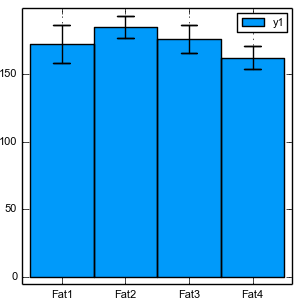

In [46]:
bar(1:4, medias[:mean], xticks=(1:4,medias[:variable]), 
bar_width=0.25, yerror=(medias[:mean].-medias[:min],medias[:max].-medias[:mean]))

#### Contrastes ortogonales

In [47]:
@rput sdonuts;

Solo hay $K-1$ contrastes ortogonales, donde $K$ es el número de niveles. Por defecto, todos se comparan contra la primera categoría (`Fat1`).

In [48]:
R"""
contrasts(sdonuts$variable)
"""

RCall.RObject{RCall.RealSxp}
     Fat2 Fat3 Fat4
Fat1    0    0    0
Fat2    1    0    0
Fat3    0    1    0
Fat4    0    0    1


In [49]:
R"summary.lm(aov(value~variable,data=sdonuts))"

RCall.RObject{RCall.VecSxp}

Call:
aov(formula = value ~ variable, data = sdonuts)

Residuals:
   Min     1Q Median     3Q    Max 
-16.00  -7.00   0.00   5.25  23.00 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   172.000      4.101  41.943   <2e-16 ***
variableFat2   13.000      5.799   2.242   0.0365 *  
variableFat3    4.000      5.799   0.690   0.4983    
variableFat4  -10.000      5.799  -1.724   0.1001    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.04 on 20 degrees of freedom
Multiple R-squared:  0.4478,	Adjusted R-squared:  0.365 
F-statistic: 5.406 on 3 and 20 DF,  p-value: 0.006876



Si en lugar de eso queremos comparar contra el último nivel (`Fat4`). Todos los contrastes deben sumar `0`:

In [50]:
R"contrastmatrix <- cbind( c(1,0,0,-1), c(0,1,0,-1), c(0,0,1,-1) )"

RCall.RObject{RCall.RealSxp}
     [,1] [,2] [,3]
[1,]    1    0    0
[2,]    0    1    0
[3,]    0    0    1
[4,]   -1   -1   -1


In [51]:
R"""
contrasts(sdonuts$variable) <- contrastmatrix

contrasts(sdonuts$variable)
"""

RCall.RObject{RCall.RealSxp}
     [,1] [,2] [,3]
Fat1    1    0    0
Fat2    0    1    0
Fat3    0    0    1
Fat4   -1   -1   -1


In [52]:
R"summary.lm(aov(value~variable,data=sdonuts))"

RCall.RObject{RCall.VecSxp}

Call:
aov(formula = value ~ variable, data = sdonuts)

Residuals:
   Min     1Q Median     3Q    Max 
-16.00  -7.00   0.00   5.25  23.00 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  173.750      2.050  84.739  < 2e-16 ***
variable1     -1.750      3.551  -0.493  0.62755    
variable2     11.250      3.551   3.168  0.00484 ** 
variable3      2.250      3.551   0.634  0.53355    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.04 on 20 degrees of freedom
Multiple R-squared:  0.4478,	Adjusted R-squared:  0.365 
F-statistic: 5.406 on 3 and 20 DF,  p-value: 0.006876



In [53]:
medias[:diff] = medias[:mean] .- 173.750
medias

,variable,mean,min,max,diff
1,Fat1,172.0,157.99878223558633,186.00121776441367,-1.75
2,Fat2,185.0,176.8440551864332,193.1559448135668,11.25
3,Fat3,176.0,165.63234067694603,186.36765932305397,2.25
4,Fat4,162.0,153.3716221124483,170.6283778875517,-11.75


### Alternativa no paramétricas al ANOVA

> In case normality is violated a rank type of test is more appropriate. In
particular, to test the null-hypothesis of equal distributions of groups *[...]* the [**Kruskal-Wallis rank sum test**](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) is recommended. This
    test can very well be seen as a generalization of the [**Wilcoxon test**](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) for testing
the equality of two distributions. Because it is based on ranking the data,
it is highly robust against non-normality, it, however, does not estimate the
size of experimental effects.
>> *Krijnen, Wim P. "Applied statistics for bioinformatics using R." Institute for Life Science and Technology, Hanze University (2009).*

In [54]:
donuts

,Fat1,Fat2,Fat3,Fat4
1,164.0,178.0,175.0,155.0
2,172.0,191.0,193.0,166.0
3,168.0,197.0,178.0,149.0
4,177.0,182.0,171.0,164.0
5,156.0,185.0,163.0,170.0
6,195.0,177.0,176.0,168.0


In [55]:
KruskalWallisTest(donuts[:Fat1],donuts[:Fat2],donuts[:Fat3],donuts[:Fat4])

Kruskal-Wallis rank sum test (chi-square approximation)
-------------------------------------------------------
Population details:
    parameter of interest:   Location parameters
    value under h_0:         all equal
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.007980479499903971 (very significant)

Details:
    number of observation in each group: [6,6,6,6]
    χ²-statistic:                        11.832244483159132
    rank sums:                           [67.5,117.0,81.5,34.0]
    degrees of freedom:                  3
    adjustment for ties:                 0.9982608695652174


In [56]:
R"kruskal.test(sdonuts$value, sdonuts$variable)"

RCall.RObject{RCall.VecSxp}

	Kruskal-Wallis rank sum test

data:  sdonuts$value and sdonuts$variable
Kruskal-Wallis chi-squared = 11.832, df = 3, p-value = 0.00798



In [57]:
R"""
# install.packages("PMCMR")
library(PMCMR)
posthoc.kruskal.nemenyi.test(sdonuts$value, sdonuts$variable)
"""

Attaching package: ‘PMCMR’

The following object is masked from ‘package:agricolae’:

    durbin.test

  Ties are present, p-values are not corrected.


RCall.RObject{RCall.VecSxp}

	Pairwise comparisons using Tukey and Kramer (Nemenyi) test	
                   with Tukey-Dist approximation for independent samples 

data:  sdonuts$value and sdonuts$variable 

     Fat1   Fat2   Fat3  
Fat2 0.1802 -      -     
Fat3 0.9406 0.4685 -     
Fat4 0.5198 0.0039 0.2117

P value adjustment method: none 


#### [Friedman test](https://en.wikipedia.org/wiki/Friedman_test)

> Similar to the parametric repeated measures ANOVA, it is used to detect differences in treatments across multiple test attempts. The procedure involves ranking each row (or block) together, then considering the values of ranks by columns. Applicable to complete block designs *[...]* example *[...]*:  
$n$ wine judges each rate $k$ different wines. Are any wines ranked consistently higher or lower than the others?  
The Friedman test is used for one-way repeated measures analysis of variance by ranks.

#### [Cochran's Q test](https://en.wikipedia.org/wiki/Cochran%27s_Q_test)

> In statistics, in the analysis of two-way randomized block designs where the response variable can take only two possible outcomes (coded as 0 and 1), Cochran's Q test is a non-parametric statistical test to verify whether k treatments have identical effects.*[...]*   
> Requires that there only be a binary response (success/failure or 1/0) and that there be 2 or more matched groups (groups of the same size). The test assesses whether the proportion of successes is the same between groups.

> Cochran's Q test is based on the following assumptions:  
1 - A large sample approximation; in particular, it assumes that b is "large".  
2 - The blocks were randomly selected from the population of all possible blocks.  
3 - The outcomes of the treatments can be coded as binary responses (i.e., a "0" or "1") in a way that is common to all treatments within each block.

[Cochran’s Q test en Python](http://statsmodels.sourceforge.net/stable/generated/statsmodels.sandbox.stats.runs.cochrans_q.html#statsmodels.sandbox.stats.runs.cochrans_q)

> Rows are blocks and columns are treatments.

In [58]:
using PyCall

In [59]:
@pyimport statsmodels.sandbox.stats.runs as py_stats

In [60]:
mat = [ 1  0  0
        1  1  0
        1  0  0
        1  0  0
        1  1  0
        1  1  0
        1  1  0
        0  0  1 ]

8x3 Array{Int64,2}:
 1  0  0
 1  1  0
 1  0  0
 1  0  0
 1  1  0
 1  1  0
 1  1  0
 0  0  1

In [61]:
py_stats.cochrans_q(mat)

(6.75,0.034218118311666025)